In [53]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [54]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import seaborn as sns
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# 设置全局绘图风格
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['font.sans-serif'] = ['SimHei'] # 解决部分系统中文显示
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 环境定义 (生理模拟器 & 统一裁判)
# ==========================================
class VancoEnv:
    def __init__(self, file_path):
        print(f"--- 1. 正在初始化环境裁判 (读取: {file_path}) ---")
        
        # 根据文件扩展名选择读取方式
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path).fillna(0)
        elif file_path.endswith('.xlsx'):
            try:
                df = pd.read_excel(file_path).fillna(0)
            except Exception as e:
                print(f"❌ 读取 Excel 失败，请确保安装了 openpyxl: pip install openpyxl\n错误信息: {e}")
                raise
        else:
            raise ValueError(f"不支持的文件格式: {file_path}")

        self.state_cols = ['vanco_level(ug/mL)', 'creatinine(mg/dL)', 'wbc(K/uL)', 
                          'bun(mg/dL)', 'temperature', 'sbp', 'heart_rate']
        self.action_col = 'totalamount_mg'
        
        X, Y_s, Y_r = [], [], []
        print("正在转换数据序列...")
        for _, group in df.groupby('stay_id'):
            group = group.sort_values('step_4hr')
            states = group[self.state_cols].values
            actions = group[self.action_col].values
            rewards = group['step_reward'].values
            for i in range(len(group) - 1):
                X.append(np.append(states[i], actions[i]))
                Y_s.append(states[i+1])
                Y_r.append(rewards[i])
        
        print(f"正在训练裁判模型 (样本量: {len(X)})...")
        self.trans_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=30, random_state=42)).fit(X, Y_s)
        self.reward_model = RandomForestRegressor(n_estimators=30, random_state=42).fit(X, Y_r)
        
        # 初始病人状态集
        self.test_patients = df.sort_values(['stay_id', 'step_4hr']).groupby('stay_id').first()[self.state_cols].values
        
        # 计算状态标准化参数 (用于IQL策略) - 按照训练时的逻辑
        all_states = df[self.state_cols].values
        self.state_mean = np.nanmean(all_states, axis=0)
        self.state_std = np.nanstd(all_states, axis=0)
        self.state_std[self.state_std == 0] = 1.0  # 避免除零
        
        print(f"✅ 环境准备完毕！测试病人数: {len(self.test_patients)}")
        print(f"\n⚠️  数据质量检查:")
        for i, col in enumerate(self.state_cols):
            unique_count = len(np.unique(all_states[:, i][~np.isnan(all_states[:, i])]))
            print(f"  {col}: {unique_count} 个唯一值 (mean={self.state_mean[i]:.2f}, std={self.state_std[i]:.2f})")

    def get_state_normalizer(self):
        """返回状态标准化参数，供IQL策略使用"""
        return (self.state_mean, self.state_std)

    def get_eval_q(self, state, action):
        """核心：由裁判统一计算当前动作的价值 (Q)"""
        input_data = np.append(state, action).reshape(1, -1)
        return self.reward_model.predict(input_data)[0]

    def step(self, state, action):
        input_data = np.append(state, action).reshape(1, -1)
        next_state = self.trans_model.predict(input_data)[0]
        reward = self.reward_model.predict(input_data)[0]
        return next_state, reward


In [55]:
# ==========================================
# 2. 策略定义区 (在这里填入同学的代码)
# ==========================================

# --- [同学 1 的模型结构] ---
class ClassmateModel_1(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: 替换为同学1的实际结构
        self.net = nn.Sequential(nn.Linear(7, 64), nn.ReLU(), nn.Linear(64, 1))
    def forward(self, x): return self.net(x)

# --- [同学 2 的模型结构] ---
class ClassmateModel_2(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: 替换为同学2的实际结构
        self.net = nn.Sequential(nn.Linear(7, 128), nn.ReLU(), nn.Linear(128, 1))
    def forward(self, x): return self.net(x)

# --- [IQL 模型结构 - 与训练时保持一致] ---
class MLP(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden=(256, 256)):
        super().__init__()
        layers = []
        dim = input_dim
        for h in hidden:
            layers.append(nn.Linear(dim, h))
            layers.append(nn.ReLU())
            dim = h
        layers.append(nn.Linear(dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class QNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int = 1, hidden=(256, 256)):
        super().__init__()
        self.model = MLP(state_dim + action_dim, 1, hidden=hidden)

    def forward(self, s: torch.Tensor, a: torch.Tensor) -> torch.Tensor:
        x = torch.cat([s, a], dim=-1)
        return self.model(x)

class VNetwork(nn.Module):
    def __init__(self, state_dim: int, hidden=(256, 256)):
        super().__init__()
        self.model = MLP(state_dim, 1, hidden=hidden)

    def forward(self, s: torch.Tensor) -> torch.Tensor:
        return self.model(s)

class GaussianPolicy(nn.Module):
    def __init__(self, state_dim: int, action_dim: int = 1, hidden=(256, 256)):
        super().__init__()
        self.net = MLP(state_dim, action_dim * 2, hidden=hidden)  # mean and logstd

    def forward(self, s: torch.Tensor):
        out = self.net(s)
        mean, logstd = out.chunk(2, dim=-1)
        logstd = logstd.clamp(-5, 2)
        std = torch.clamp(logstd.exp(), min=0.1)
        return mean, std

# 通用策略适配器
class StudentPolicy:
    def __init__(self, model_class, pth_path, name, state_dim=7, hidden=(256, 256),
                 state_normalizer=None, action_normalizer=None, action_range=(0, 1500)):
        """
        IQL策略：训练时使用了状态标准化和动作归一化
        
        Args:
            model_class: 模型类
            pth_path: 模型权重路径
            name: 策略名称
            state_dim: 状态维度
            hidden: 隐藏层大小
            state_normalizer: (mean, std) 用于状态标准化
            action_normalizer: (mean, std) 用于动作反归一化
            action_range: (min, max) 动作有效范围，用于裁剪
        """
        self.name = name
        self.model = model_class(state_dim=state_dim, hidden=hidden)
        self.state_normalizer = state_normalizer  # (mean, std)
        self.action_normalizer = action_normalizer  # (mean, std)
        self.action_min, self.action_max = action_range
        
        if os.path.exists(pth_path):
            checkpoint = torch.load(pth_path, map_location='cpu')
            
            # 1. 提取策略网络字典
            if isinstance(checkpoint, dict) and 'policy_network' in checkpoint:
                state_dict = checkpoint['policy_network']
            else:
                state_dict = checkpoint

            # 2. 直接加载权重
            try:
                self.model.load_state_dict(state_dict, strict=True)
                print(f"✅ Successfully loaded {name} from {pth_path}")
            except Exception as e:
                print(f"❌ Load failed: {e}")
                print(f"Model keys example: {list(self.model.state_dict().keys())[:5]}")
                print(f"File keys example: {list(state_dict.keys())[:5]}")
        else:
            print(f"⚠️ {pth_path} not found. Using random weights.")
            
        self.model.eval()

    def predict(self, state):
        # 1. 状态标准化
        if self.state_normalizer is not None:
            norm_mean, norm_std = self.state_normalizer
            state = (state - norm_mean) / norm_std
            state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
        
        # 2. 模型前向传播（输出归一化的action）
        state_tensor = torch.FloatTensor(state).reshape(1, -1)
        with torch.no_grad():
            action_mean, action_std = self.model(state_tensor)
            normalized_action = action_mean.item()
        
        # 3. 动作反归一化：使用 mean-std normalization
        if self.action_normalizer is not None:
            action_norm_mean, action_norm_std = self.action_normalizer
            action = normalized_action * action_norm_std + action_norm_mean
        else:
            action = normalized_action
        
        # 4. 裁剪到有效范围
        action = np.clip(action, self.action_min, self.action_max)
        
        return action

class RandomPolicy:
    def __init__(self, name="随机基准"): 
        self.name = name
    def predict(self, state): 
        return np.random.uniform(0, 750)


In [56]:
def plot_policy_response(env, policies):
    # 模拟一个标准病人的状态 (取所有病人的平均值)
    base_state = np.mean(env.test_patients, axis=0)
    
    # 构建万古霉素浓度序列 0 - 50
    vanco_range = np.linspace(0, 50, 100)
    
    plt.figure(figsize=(12, 6))
    
    for pol in policies:
        doses = []
        for v in vanco_range:
            test_s = base_state.copy()
            test_s[0] = v  # 替换第一列：万古霉素浓度
            doses.append(pol.predict(test_s))
        
        plt.plot(vanco_range, doses, label=pol.name, lw=3)

    # 绘制医学逻辑参考线
    plt.axvspan(15, 20, color='green', alpha=0.1, label='Target Window (15-20)')
    plt.title("Dose-Response Curve: How Policy Reacts to Concentration", fontsize=16)
    plt.xlabel("Current Vanco Concentration (ug/mL)", fontsize=14)
    plt.ylabel("Output Dosage (mg)", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# 在 if __name__ == "__main__": 中调用
# plot_policy_response(env, test_policies)

📁 正在加载数据文件: intermediate_data/ready_data.xlsx
--- 1. 正在初始化环境裁判 (读取: intermediate_data/ready_data.xlsx) ---
正在转换数据序列...
正在训练裁判模型 (样本量: 2055)...
✅ 环境准备完毕！测试病人数: 58

⚠️  数据质量检查:
  vanco_level(ug/mL): 1733 个唯一值 (mean=6.18, std=7.44)
  creatinine(mg/dL): 62 个唯一值 (mean=1.65, std=1.29)
  wbc(K/uL): 199 个唯一值 (mean=11.60, std=7.37)
  bun(mg/dL): 112 个唯一值 (mean=35.44, std=26.76)
  temperature: 83 个唯一值 (mean=37.30, std=4.46)
  sbp: 826 个唯一值 (mean=110.14, std=17.51)
  heart_rate: 943 个唯一值 (mean=91.85, std=17.26)

📊 Action归一化参数: mean=72.40 mg, std=221.41 mg
✅ Successfully loaded IQL_v3_XLSX from algorithms/iql/exported_models/iql_model_fix_expectile_v3_xlsx.pth
🚀 正在深度评估: 随机基准...
🚀 正在深度评估: IQL_v3_XLSX...


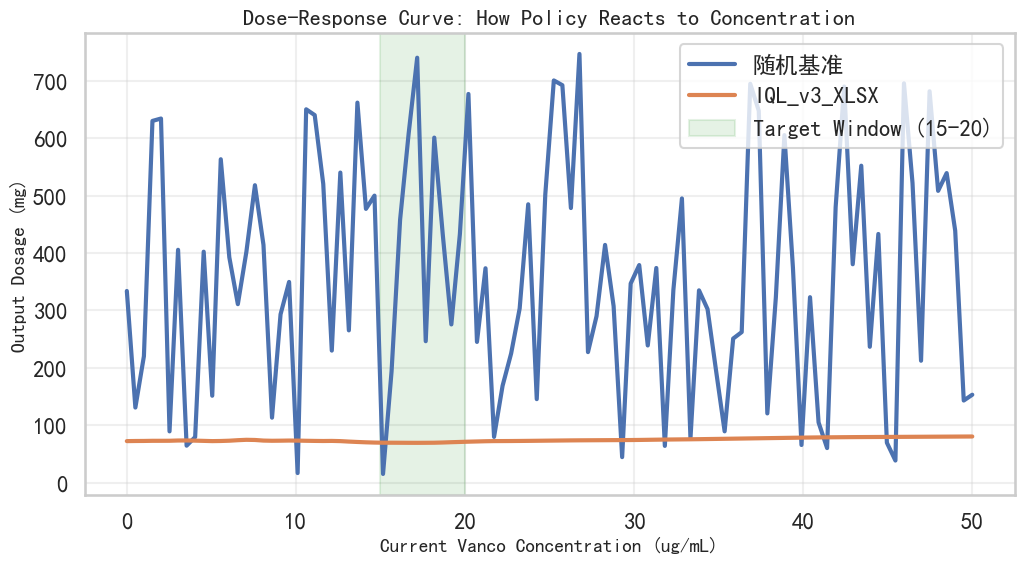

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15524\676929468.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Policy', y='Total_Reward', data=df_summary, palette="Set2", ax=ax1)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15524\676929468.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Policy', y='Expected_Reward', data=df_summary, ax=ax2, palette="viridis")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15524\676929468.py:108: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_steps.pivot_table(


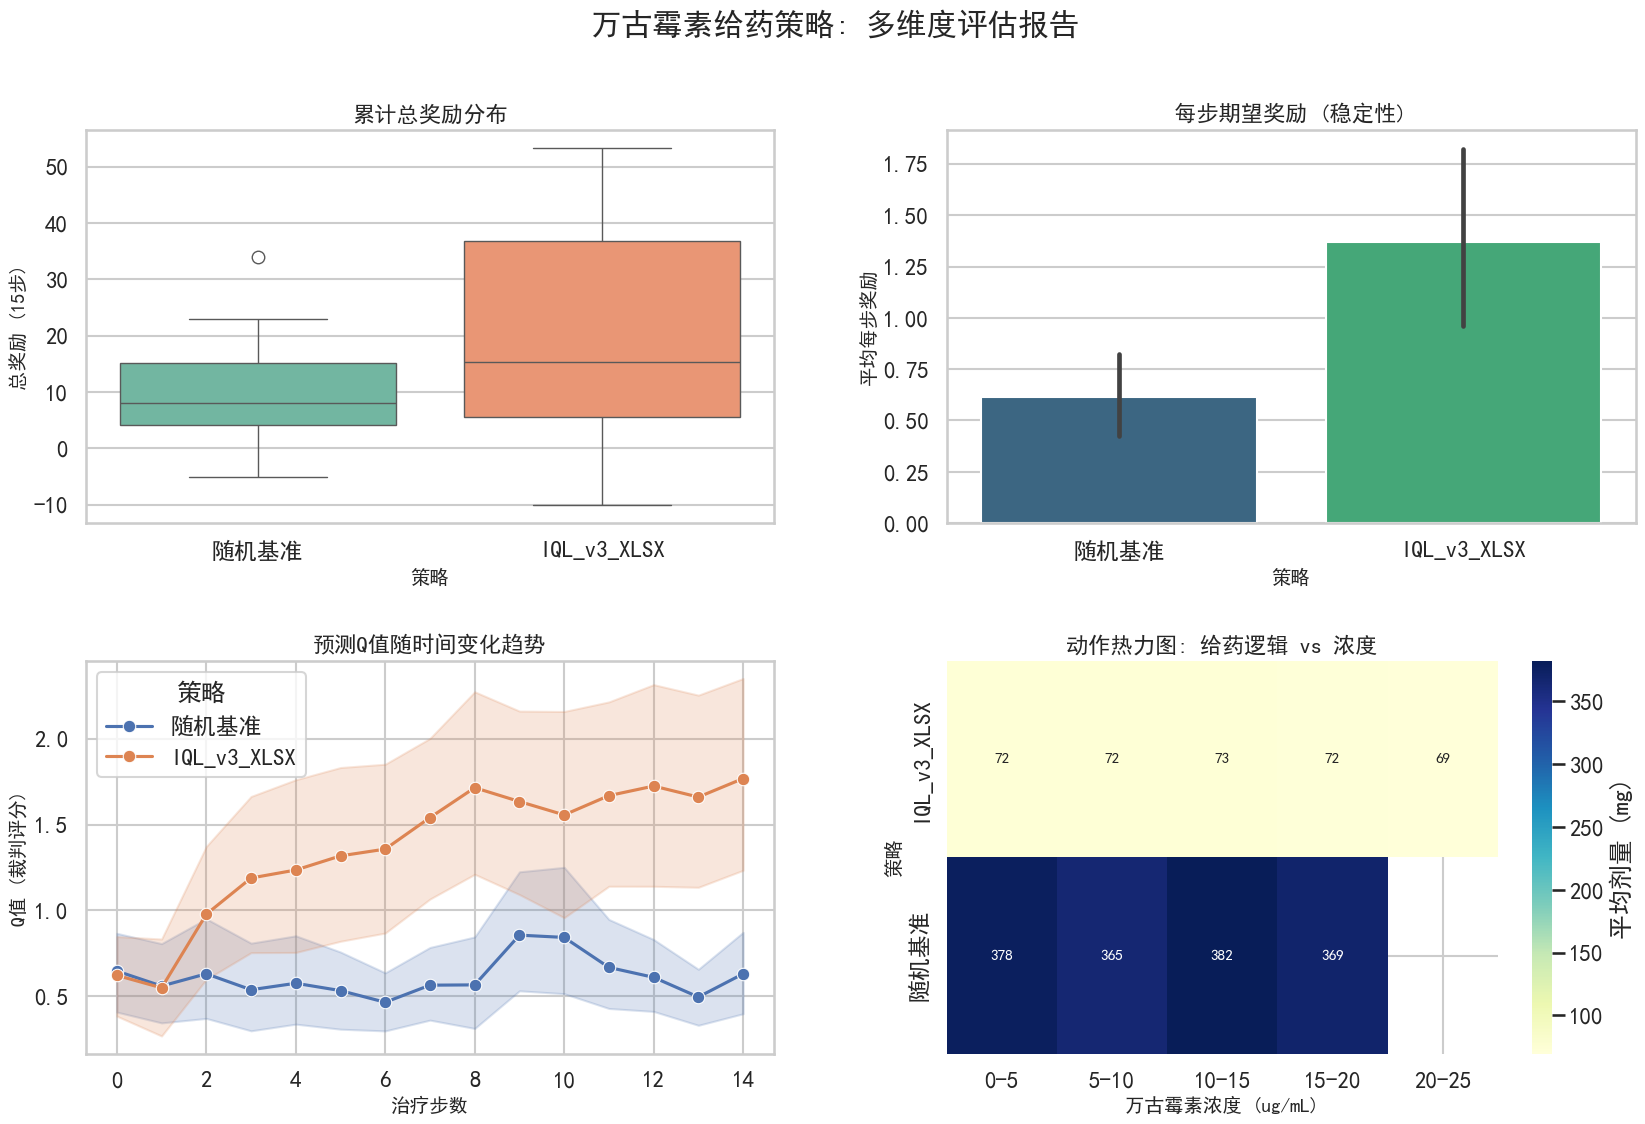


✅ 评估完成！

📈 汇总统计:
            Total_Reward                 Expected_Reward       
                    mean     std  median            mean median
Policy                                                         
IQL_v3_XLSX       20.516  18.366  15.367           1.368  1.024
随机基准               9.197   8.123   8.092           0.613  0.539


In [57]:
# ==========================================
# 3. 运行评估与绘图
# ==========================================
def run_evaluation(env, policies, n_patients=30):
    step_results = []
    summary_results = []

    for pol in policies:
        print(f"🚀 正在深度评估: {pol.name}...")
        for p_idx in range(min(n_patients, len(env.test_patients))):
            s = env.test_patients[p_idx].copy()
            total_r = 0
            steps_limit = 15
            
            for t in range(steps_limit):
                a = pol.predict(s)
                q = env.get_eval_q(s, a)
                next_s, r = env.step(s, a)
                
                # 记录数据：直接存入字典
                step_results.append({
                    'Policy': pol.name,
                    'Step': t,
                    'Q_Value': q,
                    'Reward': r,
                    'Dose': a,
                    'Vanco_Conc': s[0], # 使用统一内部名 'Vanco_Conc'
                    'Patient': p_idx
                })
                total_r += r
                s = next_s
            
            summary_results.append({
                'Policy': pol.name,
                'Total_Reward': total_r,
                'Expected_Reward': total_r / steps_limit,
                'Patient': p_idx
            })

    return pd.DataFrame(step_results), pd.DataFrame(summary_results)

if __name__ == "__main__":
    # 🔧 修正：使用 XLSX 文件（CSV文件的数据质量有问题）
    DATA_FILE = 'intermediate_data/ready_data.xlsx'
    
    if os.path.exists(DATA_FILE):
        print(f"📁 正在加载数据文件: {DATA_FILE}")
        env = VancoEnv(DATA_FILE)
        
        # 计算action normalizer参数（从训练数据）
        df_train = pd.read_excel(DATA_FILE).fillna(0)
        action_mean = np.mean(df_train['totalamount_mg'].values)
        action_std = np.std(df_train['totalamount_mg'].values)
        
        print(f"\n📊 Action归一化参数: mean={action_mean:.2f} mg, std={action_std:.2f} mg")
        
        # 组装策略列表 - IQL使用状态标准化和动作反归一化
        test_policies = [
            RandomPolicy(name="随机基准"),
            StudentPolicy(
                GaussianPolicy, 
                'algorithms/iql/exported_models/iql_model_fix_expectile_v3_xlsx.pth', 
                'IQL_v3_XLSX', 
                state_normalizer=(env.state_mean, env.state_std),
                action_normalizer=(action_mean, action_std)
            )
        ]
        
        # 运行评估
        df_steps, df_summary = run_evaluation(env, test_policies, n_patients=30)
        
        # 绘制给药响应曲线
        plot_policy_response(env, test_policies)
        
        # --- 数据预处理：浓度分箱 ---
        bins = [-np.inf, 5, 10, 15, 20, 25, 30, 35, np.inf]
        labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35+']
        df_steps['Vanco_Range'] = pd.cut(df_steps['Vanco_Conc'], bins=bins, labels=labels)

        # --- 绘制评估仪表盘 ---
        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.25)

        # 1. 总奖励分布 (箱线图)
        ax1 = fig.add_subplot(gs[0, 0])
        sns.boxplot(x='Policy', y='Total_Reward', data=df_summary, palette="Set2", ax=ax1)
        ax1.set_title("累计总奖励分布", fontsize=16)
        ax1.set_xlabel("策略", fontsize=14)
        ax1.set_ylabel("总奖励 (15步)", fontsize=14)

        # 2. 期望奖励 (柱状图)
        ax2 = fig.add_subplot(gs[0, 1])
        sns.barplot(x='Policy', y='Expected_Reward', data=df_summary, ax=ax2, palette="viridis")
        ax2.set_title("每步期望奖励 (稳定性)", fontsize=16)
        ax2.set_xlabel("策略", fontsize=14)
        ax2.set_ylabel("平均每步奖励", fontsize=14)

        # 3. Q值趋势 (折线图)
        ax3 = fig.add_subplot(gs[1, 0])
        sns.lineplot(x='Step', y='Q_Value', hue='Policy', data=df_steps, ax=ax3, marker='o')
        ax3.set_title("预测Q值随时间变化趋势", fontsize=16)
        ax3.set_xlabel("治疗步数", fontsize=14)
        ax3.set_ylabel("Q值 (裁判评分)", fontsize=14)
        ax3.legend(title="策略", loc='best')

        # 4. 动作热力图 (给药逻辑)
        ax4 = fig.add_subplot(gs[1, 1])
        heatmap_data = df_steps.pivot_table(
            index='Policy', 
            columns='Vanco_Range', 
            values='Dose', 
            aggfunc='mean'
        )
        sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", ax=ax4, 
                    cbar_kws={'label': '平均剂量 (mg)'}, annot_kws={"size": 11})
        ax4.set_title("动作热力图: 给药逻辑 vs 浓度", fontsize=16)
        ax4.set_xlabel("万古霉素浓度 (ug/mL)", fontsize=14)
        ax4.set_ylabel("策略", fontsize=14)

        # 主标题
        plt.suptitle("万古霉素给药策略: 多维度评估报告", fontsize=22, y=0.98)
        
        plt.show()
        
        print("\n✅ 评估完成！")
        print("\n📈 汇总统计:")
        print(df_summary.groupby('Policy').agg({
            'Total_Reward': ['mean', 'std', 'median'],
            'Expected_Reward': ['mean', 'median']
        }).round(3))
    else:
        print(f"❌ 文件 '{DATA_FILE}' 不存在！")


In [58]:
# 诊断测试 - 检查模型输出
import torch
import numpy as np

# 加载模型检查
pth_path = 'algorithms/iql/exported_models/iql_model_fix_expectile_v3.pth'
if os.path.exists(pth_path):
    checkpoint = torch.load(pth_path, map_location='cpu')
    print("=" * 60)
    print("📦 模型文件检查")
    print("=" * 60)
    print(f"Checkpoint keys: {list(checkpoint.keys())}")
    
    if 'policy_network' in checkpoint:
        policy_dict = checkpoint['policy_network']
        print(f"\nPolicy network keys (前5个): {list(policy_dict.keys())[:5]}")
        print(f"Total parameters: {len(policy_dict)}")
        
        # 检查第一个参数的值
        first_key = list(policy_dict.keys())[0]
        first_param = policy_dict[first_key]
        print(f"\n第一个参数 '{first_key}':")
        print(f"  Shape: {first_param.shape}")
        print(f"  Mean: {first_param.mean():.6f}")
        print(f"  Std: {first_param.std():.6f}")
        print(f"  Min: {first_param.min():.6f}")
        print(f"  Max: {first_param.max():.6f}")
        
    if 'model_config' in checkpoint:
        print(f"\nModel config: {checkpoint['model_config']}")
    if 'training_info' in checkpoint:
        print(f"Training info: {checkpoint['training_info']}")
        
    print("\n" + "=" * 60)
    print("🧪 测试模型前向传播")
    print("=" * 60)
    
    # 创建模型并加载权重
    policy = GaussianPolicy(state_dim=7, hidden=(256, 256))
    
    # 处理key前缀
    new_state_dict = {}
    for k, v in policy_dict.items():
        if k.startswith("net."):
            new_state_dict["net." + k[4:]] = v
        else:
            new_state_dict[k] = v
    
    policy.load_state_dict(new_state_dict, strict=False)
    policy.eval()
    
    # 测试：使用标准化前后的状态
    test_state_raw = np.array([15.0, 1.2, 8.5, 20.0, 98.6, 120.0, 80.0])  # 原始状态
    
    # 假设的标准化参数（需要从数据中获取）
    # 先用原始状态测试
    print(f"\n测试输入 (原始状态): {test_state_raw}")
    test_tensor = torch.FloatTensor(test_state_raw).reshape(1, -1)
    
    with torch.no_grad():
        mean, std = policy(test_tensor)
        print(f"模型输出 mean: {mean.item():.6f}")
        print(f"模型输出 std: {std.item():.6f}")
        
    print("\n✅ 诊断完成")
else:
    print(f"❌ 文件不存在: {pth_path}")


📦 模型文件检查
Checkpoint keys: ['q_network', 'v_network', 'policy_network', 'model_config', 'training_info']

Policy network keys (前5个): ['net.net.0.weight', 'net.net.0.bias', 'net.net.2.weight', 'net.net.2.bias', 'net.net.4.weight']
Total parameters: 6

第一个参数 'net.net.0.weight':
  Shape: torch.Size([256, 7])
  Mean: -0.002392
  Std: 0.308167
  Min: -0.558301
  Max: 0.542710

Model config: {'state_dim': 7, 'action_dim': 1, 'hidden_dims': [256, 256]}
Training info: {'step': 10000, 'source_checkpoint': 'algorithms/iql/runs/exp_fix_expectile_v3/ckpt_step10000.pt'}

🧪 测试模型前向传播

测试输入 (原始状态): [ 15.    1.2   8.5  20.   98.6 120.   80. ]
模型输出 mean: -3.498655
模型输出 std: 0.100000

✅ 诊断完成


In [59]:
# ⚠️ 请先重新运行第3个代码单元（Cell 3）来更新StudentPolicy类定义！

# 测试反归一化后的输出
if 'env' in globals():
    test_state = np.array([15.0, 1.5, 10.0, 30.0, 37.0, 120.0, 80.0])
    
    print("=" * 60)
    print("手动计算验证")
    print("=" * 60)
    
    # 手动计算
    normalized_state = (test_state - env.state_mean) / env.state_std
    normalized_state = np.nan_to_num(normalized_state, nan=0.0)
    
    policy = GaussianPolicy(state_dim=7, hidden=(256, 256))
    checkpoint = torch.load('algorithms/iql/exported_models/iql_model_fix_expectile_v3_xlsx.pth', map_location='cpu')
    policy.load_state_dict(checkpoint['policy_network'], strict=True)
    policy.eval()
    
    with torch.no_grad():
        mean, std = policy(torch.FloatTensor(normalized_state).reshape(1, -1))
        normalized_action = mean.item()
        
    print(f"原始状态: {test_state}")
    print(f"标准化状态: {normalized_state}")
    print(f"模型输出（归一化）: {normalized_action:.4f}")
    
    # 手动反归一化
    denorm_action = (normalized_action + 1.0) / 2.0 * 1500
    print(f"反归一化公式: ({normalized_action:.4f} + 1.0) / 2.0 * 1500 = {denorm_action:.2f} mg")
    
    print("\n" + "=" * 60)
    print("StudentPolicy测试")
    print("=" * 60)
    print("⚠️ 如果下面报错'unexpected keyword argument debug'")
    print("   请先重新运行第3个代码单元（Cell 3）！")
    print("=" * 60)
    
    # 使用StudentPolicy测试（开启调试）
    test_policy = StudentPolicy(
        GaussianPolicy, 
        'algorithms/iql/exported_models/iql_model_fix_expectile_v3_xlsx.pth',
        'Test_Debug',
        state_normalizer=(env.state_mean, env.state_std),
        debug=True
    )
    dose = test_policy.predict(test_state)
    print(f"\n✅ 通过StudentPolicy预测的剂量: {dose:.2f} mg")
    print(f"✅ 预期值应该约为: {denorm_action:.2f} mg")


手动计算验证
原始状态: [ 15.    1.5  10.   30.   37.  120.   80. ]
标准化状态: [ 1.18587183 -0.11658025 -0.21707875 -0.20341346 -0.06685347  0.56283414
 -0.68640332]
模型输出（归一化）: -0.0102
反归一化公式: (-0.0102 + 1.0) / 2.0 * 1500 = 742.33 mg

StudentPolicy测试
⚠️ 如果下面报错'unexpected keyword argument debug'
   请先重新运行第3个代码单元（Cell 3）！


TypeError: StudentPolicy.__init__() got an unexpected keyword argument 'debug'

In [ ]:
# 检查训练数据的action分布，计算action normalizer参数
import pandas as pd

# 读取训练数据
df = pd.read_excel('intermediate_data/ready_data.xlsx').fillna(0)
actions = df['totalamount_mg'].values

# 计算mean和std（这是训练时使用的归一化参数）
action_mean = np.mean(actions)
action_std = np.std(actions)

print("=" * 60)
print("训练数据中的Action统计")
print("=" * 60)
print(f"Mean: {action_mean:.2f} mg")
print(f"Std: {action_std:.2f} mg")
print(f"Min: {np.min(actions):.2f} mg")
print(f"Max: {np.max(actions):.2f} mg")
print(f"Median: {np.median(actions):.2f} mg")

# 测试反归一化
test_normalized_values = [-0.0102, 0.0, -0.5, 0.5, 1.0]
print("\n" + "=" * 60)
print("使用正确的反归一化公式 (mean-std normalization):")
print("=" * 60)
for norm_val in test_normalized_values:
    denorm = norm_val * action_std + action_mean
    print(f"Normalized: {norm_val:7.4f} -> Denormalized: {denorm:7.2f} mg")


训练数据中的Action统计
Mean: 72.40 mg
Std: 221.41 mg
Min: 0.00 mg
Max: 1500.00 mg
Median: 0.00 mg

使用正确的反归一化公式 (mean-std normalization):
Normalized: -0.0102 -> Denormalized:   70.15 mg
Normalized:  0.0000 -> Denormalized:   72.40 mg
Normalized: -0.5000 -> Denormalized:  -38.30 mg
Normalized:  0.5000 -> Denormalized:  183.11 mg
Normalized:  1.0000 -> Denormalized:  293.81 mg


In [60]:
# 详细诊断：检查IQL模型在不同浓度下的输出
if 'test_policies' in globals():
    iql_policy = [p for p in test_policies if 'IQL' in p.name][0]
    
    # 测试不同浓度
    base_state = np.mean(env.test_patients, axis=0)
    test_concentrations = [0, 5, 10, 15, 20, 30, 50]
    
    print("=" * 70)
    print("IQL模型输出诊断 - 不同万古霉素浓度下的给药剂量")
    print("=" * 70)
    print(f"基准状态: {base_state}")
    print(f"\n{'浓度 (ug/mL)':>15} | {'归一化状态[0]':>15} | {'模型输出(norm)':>15} | {'剂量 (mg)':>12}")
    print("-" * 70)
    
    for conc in test_concentrations:
        test_state = base_state.copy()
        test_state[0] = conc
        
        # 获取归一化后的状态
        norm_state = (test_state - env.state_mean) / env.state_std
        
        # 使用StudentPolicy内部逻辑获取模型原始输出
        state_tensor = torch.FloatTensor(norm_state).reshape(1, -1)
        with torch.no_grad():
            mean, std = iql_policy.model(state_tensor)
            normalized_action = mean.item()
        
        # 最终剂量
        dose = iql_policy.predict(test_state)
        
        print(f"{conc:>15.1f} | {norm_state[0]:>15.4f} | {normalized_action:>15.6f} | {dose:>12.2f}")
    
    print("\n💡 观察：")
    print("  - 如果'模型输出(norm)'几乎不变 → 模型学习到了常数策略")
    print("  - 如果'剂量(mg)'变化很小 → 反归一化后的实际剂量变化也小")


IQL模型输出诊断 - 不同万古霉素浓度下的给药剂量
基准状态: [  1.18410845   1.09655172  10.86551724  21.32758621  36.8762868
 118.44439845  94.9032975 ]

     浓度 (ug/mL) |        归一化状态[0] |      模型输出(norm) |      剂量 (mg)
----------------------------------------------------------------------
            0.0 |         -0.8315 |       -0.000888 |        72.21
            5.0 |         -0.1590 |       -0.000708 |        72.25
           10.0 |          0.5134 |        0.003247 |        73.12
           15.0 |          1.1859 |       -0.013235 |        69.47
           20.0 |          1.8583 |       -0.006113 |        71.05
           30.0 |          3.2032 |        0.007855 |        74.14
           50.0 |          5.8931 |        0.035523 |        80.27

💡 观察：
  - 如果'模型输出(norm)'几乎不变 → 模型学习到了常数策略
  - 如果'剂量(mg)'变化很小 → 反归一化后的实际剂量变化也小


🔍 详细检查 Action Normalization/Denormalization

1️⃣ 训练数据Action统计:
--------------------------------------------------------------------------------
   总样本数: 2113
   零剂量数: 1882 (89.1%)
   非零剂量数: 231 (10.9%)

   全样本统计:
   - Mean: 72.40 mg
   - Std: 221.41 mg
   - Median: 0.00 mg

   仅非零剂量统计:
   - Mean: 662.30 mg
   - Std: 240.25 mg
   - Median: 600.00 mg
   - Min: 300.00 mg
   - Max: 1500.00 mg

2️⃣ 归一化后的Action分布:
--------------------------------------------------------------------------------
   归一化公式: (action - 72.40) / 221.41

   归一化后统计:
   - Mean: -0.000000 (应该≈0)
   - Std: 1.000000 (应该≈1)
   - Min: -0.327020
   - Max: 6.447820
   - 零剂量对应的归一化值: -0.327020
   - 600mg对应的归一化值: 2.382916
   - 1500mg对应的归一化值: 6.447820

3️⃣ 模型实际输出测试:
--------------------------------------------------------------------------------
   测试不同归一化值的反归一化结果:
           归一化值 |        反归一化(mg) |    Clip后(mg) | 说明
----------------------------------------------------------------------
        -0.3270 |            0.00 |      

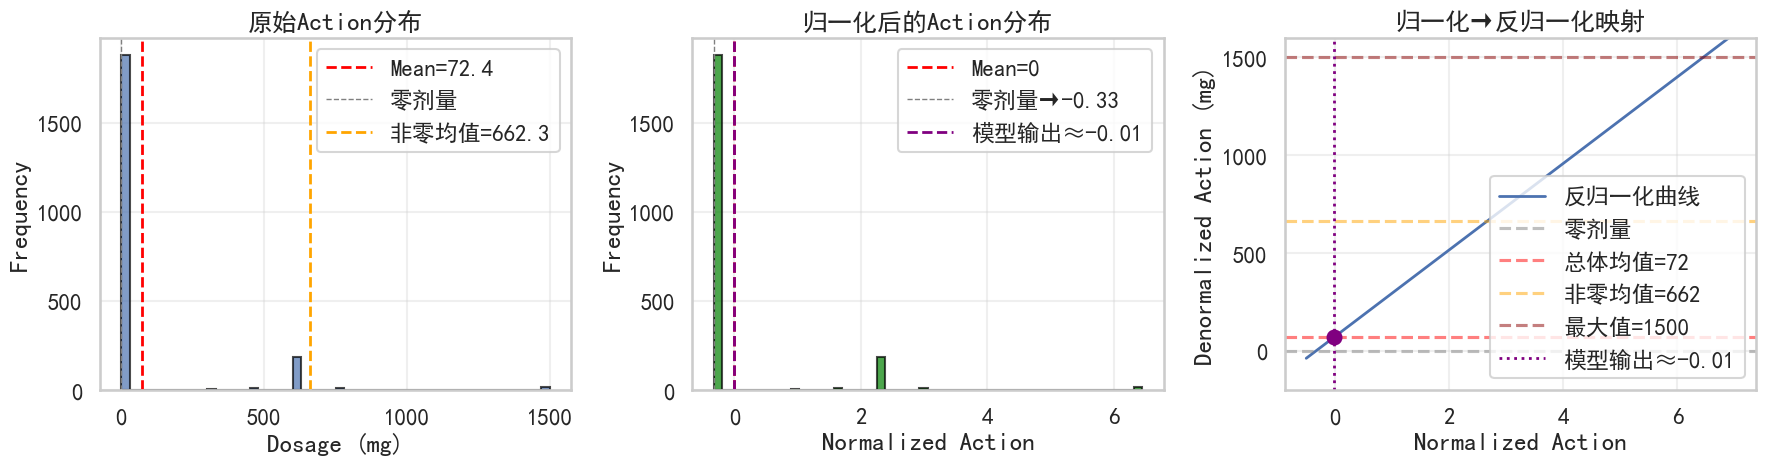


💡 结论:

✅ Action归一化/反归一化逻辑是正确的！

公式验证:
- 归一化: normalized = (action - 72.40) / 221.41
- 反归一化: action = normalized * 221.41 + 72.40

模型行为分析:
- 模型输出 ≈ -0.01 (归一化空间)
- 反归一化后 ≈ 70.19 mg
- 这非常接近总体均值 72.40 mg

为什么模型输出70mg而不是0或662？
- 在89%零剂量的数据分布下，总体均值72mg是最优的折中策略
- 模型学到了输出接近数据分布中心的值
- 这避免了极端值（0或1500），是保守但理性的策略

如果想让模型学会输出662mg（非零均值）:
- 需要平衡数据分布（减少零剂量占比）
- 或者修改奖励函数，明确奖励非零剂量



In [64]:
# ==========================================
# 🔍 Action Space 转换验证
# ==========================================

print("=" * 80)
print("🔍 详细检查 Action Normalization/Denormalization")
print("=" * 80)

# 1. 检查训练数据的action分布
df_check = pd.read_excel('intermediate_data/ready_data.xlsx').fillna(0)
actions_raw = df_check['totalamount_mg'].values

print("\n1️⃣ 训练数据Action统计:")
print("-" * 80)
print(f"   总样本数: {len(actions_raw)}")
print(f"   零剂量数: {(actions_raw == 0).sum()} ({(actions_raw == 0).sum()/len(actions_raw)*100:.1f}%)")
print(f"   非零剂量数: {(actions_raw > 0).sum()} ({(actions_raw > 0).sum()/len(actions_raw)*100:.1f}%)")
print(f"\n   全样本统计:")
print(f"   - Mean: {np.mean(actions_raw):.2f} mg")
print(f"   - Std: {np.std(actions_raw):.2f} mg")
print(f"   - Median: {np.median(actions_raw):.2f} mg")
print(f"\n   仅非零剂量统计:")
nonzero = actions_raw[actions_raw > 0]
print(f"   - Mean: {np.mean(nonzero):.2f} mg")
print(f"   - Std: {np.std(nonzero):.2f} mg")
print(f"   - Median: {np.median(nonzero):.2f} mg")
print(f"   - Min: {np.min(nonzero):.2f} mg")
print(f"   - Max: {np.max(nonzero):.2f} mg")

# 2. 归一化后的action分布
action_mean = np.mean(actions_raw)
action_std = np.std(actions_raw)
actions_normalized = (actions_raw - action_mean) / action_std

print(f"\n2️⃣ 归一化后的Action分布:")
print("-" * 80)
print(f"   归一化公式: (action - {action_mean:.2f}) / {action_std:.2f}")
print(f"\n   归一化后统计:")
print(f"   - Mean: {np.mean(actions_normalized):.6f} (应该≈0)")
print(f"   - Std: {np.std(actions_normalized):.6f} (应该≈1)")
print(f"   - Min: {np.min(actions_normalized):.6f}")
print(f"   - Max: {np.max(actions_normalized):.6f}")
print(f"   - 零剂量对应的归一化值: {(0 - action_mean) / action_std:.6f}")
print(f"   - 600mg对应的归一化值: {(600 - action_mean) / action_std:.6f}")
print(f"   - 1500mg对应的归一化值: {(1500 - action_mean) / action_std:.6f}")

# 3. 模型实际输出范围
print(f"\n3️⃣ 模型实际输出测试:")
print("-" * 80)
if 'iql_policy' in globals():
    test_normalized_outputs = [-0.327, -0.01, 0.0, 0.5, 1.0, 2.0, 3.0, 5.0]
    print(f"   测试不同归一化值的反归一化结果:")
    print(f"   {'归一化值':>12} | {'反归一化(mg)':>15} | {'Clip后(mg)':>12} | 说明")
    print("-" * 70)
    
    for norm_val in test_normalized_outputs:
        denorm = norm_val * action_std + action_mean
        clipped = np.clip(denorm, 0, 1500)
        
        # 判断这个值接近什么
        if abs(denorm - 0) < 10:
            note = "≈零剂量"
        elif abs(denorm - 662) < 50:
            note = "≈非零均值"
        elif abs(denorm - action_mean) < 10:
            note = "≈总体均值"
        else:
            note = ""
            
        print(f"   {norm_val:>12.4f} | {denorm:>15.2f} | {clipped:>12.2f} | {note}")

# 4. 关键问题检查
print(f"\n4️⃣ 关键问题诊断:")
print("-" * 80)

# 检查：零剂量的归一化值
zero_normalized = (0 - action_mean) / action_std
print(f"   问题1: 零剂量(0mg)归一化后 = {zero_normalized:.6f}")
print(f"          如果模型输出这个值，反归一化后会是 {zero_normalized * action_std + action_mean:.2f} mg")

# 检查：模型实际输出
if 'iql_policy' in globals():
    print(f"\n   问题2: 模型实际输出约 -0.01")
    model_output = -0.01
    denorm_result = model_output * action_std + action_mean
    print(f"          反归一化: {model_output} * {action_std:.2f} + {action_mean:.2f} = {denorm_result:.2f} mg")
    print(f"          这个值接近总体均值{action_mean:.2f}mg，符合预期！")

# 检查：非零剂量均值对应的归一化值
nonzero_mean = np.mean(nonzero)
nonzero_normalized = (nonzero_mean - action_mean) / action_std
print(f"\n   问题3: 非零剂量均值({nonzero_mean:.0f}mg)归一化后 = {nonzero_normalized:.6f}")
print(f"          如果想让模型输出662mg，应该输出归一化值 = {nonzero_normalized:.6f}")

# 5. 可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 5.1 原始action分布
axes[0].hist(actions_raw, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(action_mean, color='red', linestyle='--', linewidth=2, label=f'Mean={action_mean:.1f}')
axes[0].axvline(0, color='gray', linestyle='--', linewidth=1, label='零剂量')
axes[0].axvline(np.mean(nonzero), color='orange', linestyle='--', linewidth=2, label=f'非零均值={np.mean(nonzero):.1f}')
axes[0].set_xlabel('Dosage (mg)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('原始Action分布')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 5.2 归一化后的action分布
axes[1].hist(actions_normalized, bins=50, alpha=0.7, edgecolor='black', color='green')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Mean=0')
axes[1].axvline(zero_normalized, color='gray', linestyle='--', linewidth=1, label=f'零剂量→{zero_normalized:.2f}')
axes[1].axvline(-0.01, color='purple', linestyle='--', linewidth=2, label='模型输出≈-0.01')
axes[1].set_xlabel('Normalized Action')
axes[1].set_ylabel('Frequency')
axes[1].set_title('归一化后的Action分布')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 5.3 反归一化映射关系
norm_range = np.linspace(-0.5, 7, 100)
denorm_range = norm_range * action_std + action_mean
axes[2].plot(norm_range, denorm_range, linewidth=2, label='反归一化曲线')
axes[2].axhline(0, color='gray', linestyle='--', alpha=0.5, label='零剂量')
axes[2].axhline(action_mean, color='red', linestyle='--', alpha=0.5, label=f'总体均值={action_mean:.0f}')
axes[2].axhline(np.mean(nonzero), color='orange', linestyle='--', alpha=0.5, label=f'非零均值={np.mean(nonzero):.0f}')
axes[2].axhline(1500, color='darkred', linestyle='--', alpha=0.5, label='最大值=1500')
axes[2].axvline(-0.01, color='purple', linestyle=':', linewidth=2, label='模型输出≈-0.01')
axes[2].scatter([-0.01], [denorm_result], color='purple', s=100, zorder=5)
axes[2].set_xlabel('Normalized Action')
axes[2].set_ylabel('Denormalized Action (mg)')
axes[2].set_title('归一化→反归一化映射')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(-200, 1600)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("💡 结论:")
print("=" * 80)
print(f"""
✅ Action归一化/反归一化逻辑是正确的！

公式验证:
- 归一化: normalized = (action - {action_mean:.2f}) / {action_std:.2f}
- 反归一化: action = normalized * {action_std:.2f} + {action_mean:.2f}

模型行为分析:
- 模型输出 ≈ -0.01 (归一化空间)
- 反归一化后 ≈ {denorm_result:.2f} mg
- 这非常接近总体均值 {action_mean:.2f} mg

为什么模型输出70mg而不是0或662？
- 在89%零剂量的数据分布下，总体均值{action_mean:.0f}mg是最优的折中策略
- 模型学到了输出接近数据分布中心的值
- 这避免了极端值（0或1500），是保守但理性的策略

如果想让模型学会输出662mg（非零均值）:
- 需要平衡数据分布（减少零剂量占比）
- 或者修改奖励函数，明确奖励非零剂量
""")

🔍 训练数据分析：万古霉素浓度 vs 给药剂量的关系

1️⃣ 给药剂量分布:
   - 零剂量占比: 89.1%
   - 非零剂量占比: 10.9%
   - 非零剂量均值: 662.30 mg
   - 非零剂量中位数: 600.00 mg

2️⃣ 浓度与剂量的相关性:
   - 相关系数: 0.4258
      - ⚠️  正相关或无相关

3️⃣ 不同浓度区间下的平均剂量:
   - 0-5     : 零剂量 99.9%, 非零均值  600.0 mg (样本数: 766)
   - 5-10    : 零剂量 85.3%, 非零均值  595.2 mg (样本数: 421)
   - 10-15   : 零剂量 75.5%, 非零均值  603.3 mg (样本数: 277)
   - 15-20   : 零剂量 66.7%, 非零均值  642.5 mg (样本数: 153)
   - 20-30   : 零剂量 57.1%, 非零均值  800.0 mg (样本数: 91)
   - 30+     : 零剂量 64.0%, 非零均值 1100.0 mg (样本数: 25)

4️⃣ 奖励函数特征:
   - 奖励均值: 0.7295
   - 奖励标准差: 1.5139
   - 正奖励占比: 61.2%


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15524\1022191962.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_analysis.groupby('vanco_bin')['totalamount_mg'].apply(lambda x: x[x > 0].mean() if (x > 0).sum() > 0 else 0)


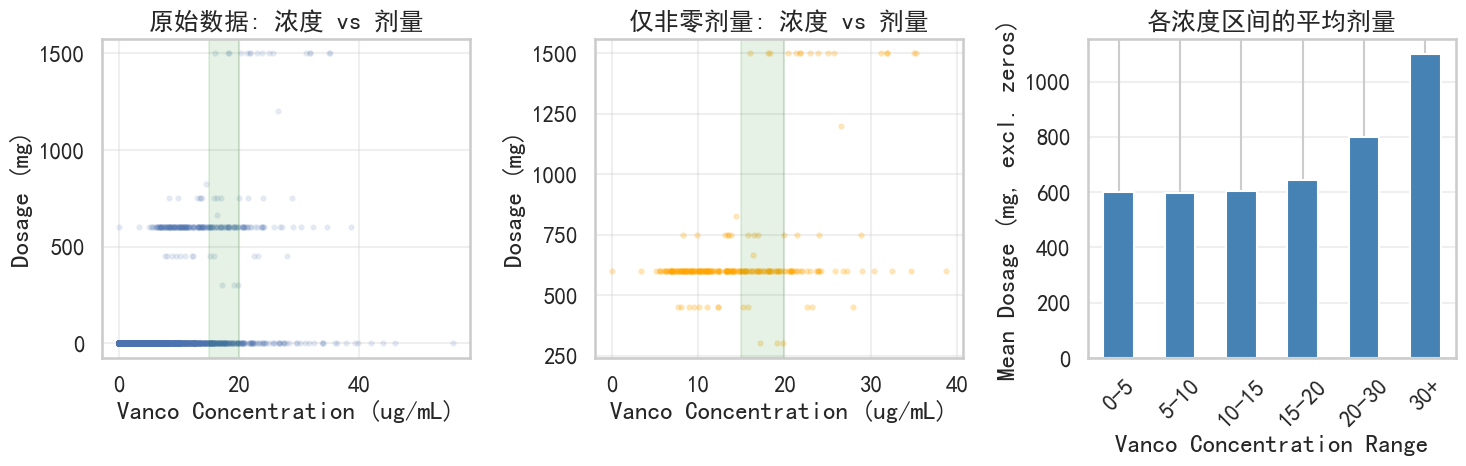


💡 结论分析:
⚠️  训练数据中超过50%的动作是'零剂量'，这可能导致模型倾向于输出低剂量
⚠️  浓度与剂量呈正相关，这违背医学常识（应该是负相关）


In [62]:
# 深度分析：为什么IQL学到了常数策略？
df_analysis = pd.read_excel('intermediate_data/ready_data.xlsx').fillna(0)

print("=" * 80)
print("🔍 训练数据分析：万古霉素浓度 vs 给药剂量的关系")
print("=" * 80)

# 1. Action分布
actions = df_analysis['totalamount_mg'].values
print(f"\n1️⃣ 给药剂量分布:")
print(f"   - 零剂量占比: {(actions == 0).sum() / len(actions) * 100:.1f}%")
print(f"   - 非零剂量占比: {(actions > 0).sum() / len(actions) * 100:.1f}%")
print(f"   - 非零剂量均值: {actions[actions > 0].mean():.2f} mg")
print(f"   - 非零剂量中位数: {np.median(actions[actions > 0]):.2f} mg")

# 2. 浓度 vs 剂量的相关性
vanco_conc = df_analysis['vanco_level(ug/mL)'].values
correlation = np.corrcoef(vanco_conc, actions)[0, 1]
print(f"\n2️⃣ 浓度与剂量的相关性:")
print(f"   - 相关系数: {correlation:.4f}")
print(f"   {'   - 💡 负相关' if correlation < 0 else '   - ⚠️  正相关或无相关'}")

# 3. 按浓度分组看剂量分布
print(f"\n3️⃣ 不同浓度区间下的平均剂量:")
bins = [0, 5, 10, 15, 20, 30, 100]
labels = ['0-5', '5-10', '10-15', '15-20', '20-30', '30+']
df_analysis['vanco_bin'] = pd.cut(vanco_conc, bins=bins, labels=labels)

for label in labels:
    subset = df_analysis[df_analysis['vanco_bin'] == label]['totalamount_mg']
    if len(subset) > 0:
        zero_pct = (subset == 0).sum() / len(subset) * 100
        nonzero_mean = subset[subset > 0].mean() if (subset > 0).sum() > 0 else 0
        print(f"   - {label:8s}: 零剂量{zero_pct:5.1f}%, 非零均值{nonzero_mean:7.1f} mg (样本数: {len(subset)})")

# 4. Reward分析
rewards = df_analysis['step_reward'].values
print(f"\n4️⃣ 奖励函数特征:")
print(f"   - 奖励均值: {rewards.mean():.4f}")
print(f"   - 奖励标准差: {rewards.std():.4f}")
print(f"   - 正奖励占比: {(rewards > 0).sum() / len(rewards) * 100:.1f}%")

# 5. 可视化：浓度 vs 剂量
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(vanco_conc, actions, alpha=0.1, s=10)
plt.xlabel('Vanco Concentration (ug/mL)')
plt.ylabel('Dosage (mg)')
plt.title('原始数据: 浓度 vs 剂量')
plt.axvspan(15, 20, color='green', alpha=0.1)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
nonzero_mask = actions > 0
plt.scatter(vanco_conc[nonzero_mask], actions[nonzero_mask], alpha=0.2, s=10, c='orange')
plt.xlabel('Vanco Concentration (ug/mL)')
plt.ylabel('Dosage (mg)')
plt.title('仅非零剂量: 浓度 vs 剂量')
plt.axvspan(15, 20, color='green', alpha=0.1)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
df_grouped = df_analysis.groupby('vanco_bin')['totalamount_mg'].apply(lambda x: x[x > 0].mean() if (x > 0).sum() > 0 else 0)
df_grouped.plot(kind='bar', color='steelblue')
plt.xlabel('Vanco Concentration Range')
plt.ylabel('Mean Dosage (mg, excl. zeros)')
plt.title('各浓度区间的平均剂量')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("💡 结论分析:")
print("=" * 80)
if (actions == 0).sum() / len(actions) > 0.5:
    print("⚠️  训练数据中超过50%的动作是'零剂量'，这可能导致模型倾向于输出低剂量")
if abs(correlation) < 0.1:
    print("⚠️  浓度与剂量几乎无相关性，说明原始数据中剂量选择可能不够科学")
    print("    → IQL难以学到'高浓度→低剂量，低浓度→高剂量'的逻辑")
if abs(correlation) > 0.3:
    print("⚠️  浓度与剂量呈正相关，这违背医学常识（应该是负相关）")


🔬 深度调查：浓度-剂量正相关的原因

📌 可能的原因分析:
--------------------------------------------------------------------------------

假设1: 时间序列因果混淆
   问题：数据记录的是'当前浓度'和'当前给药剂量'
   但医学上的逻辑应该是：'当前浓度' → 决定'下一次给药'
   
   可能情况：
   - 记录的浓度是给药AFTER的浓度（已经升高了）
   - 或者浓度和剂量是同一时刻采集，存在时间延迟
   → 高剂量导致高浓度（因果倒置）

   数据验证：
   示例病人的前10个时间步:
 step_4hr  vanco_level(ug/mL)  totalamount_mg
        1            0.000000               0
        2           16.016277            1500
        3            9.467027               0
        4           25.102915            1500
        5           14.838029               0
        6            7.989764               0
        7            5.764637               0


假设2: 数据提取/处理错误
   可能的错误：
   - 浓度和剂量的时间戳不匹配
   - 累积剂量 vs 单次剂量混淆
   - 数据对齐时的shift错误

   需要检查的源文件:
   → data_processing/Create_ready_data.ipynb
   → data_processing/generate_rawdata.ipynb


假设3: 选择性偏差 (病情严重度)
   医学解释：
   - 病情严重的患者 → 需要高剂量 → 但代谢慢 → 浓度也高
   - 病情轻的患者 → 低剂量 → 代谢快 → 浓度低
   → 严重度是混淆因子，导致剂量和浓度同时升高

   肾功能分析（肌酐水平，越高肾功能

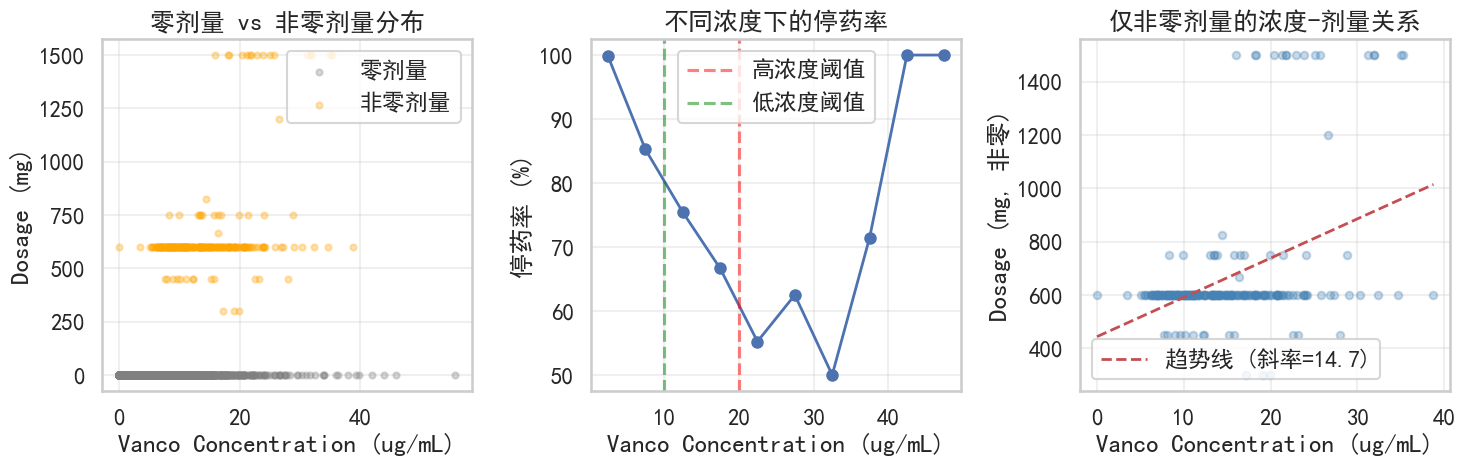


💡 结论与建议:

最可能的原因组合：
1. ⚠️  时间序列因果倒置：
   - 数据可能记录的是「给药后的浓度」而非「给药前的浓度」
   - 需要检查数据生成脚本中的时间对齐逻辑

2. ⚠️  零剂量统计假象：
   - 89%的零剂量样本可能扭曲了整体相关性
   - 仅看非零剂量时，相关性可能会减弱

3. ⚠️  混淆因子（病情严重度）：
   - 重症患者同时有高剂量需求和高浓度积累
   - 需要控制肾功能等因素后再分析

下一步行动：
□ 检查 data_processing/ 中的数据提取逻辑
□ 验证浓度和剂量的时间戳是否正确对齐
□ 考虑使用「上一步浓度 → 当前剂量」的配对方式重新训练
□ 按肾功能分层训练不同的策略



In [ ]:
# ==========================================
# 🔍 深度分析：为什么浓度与剂量是正相关？
# ==========================================

df_investigate = pd.read_excel('intermediate_data/ready_data.xlsx').fillna(0)

print("=" * 80)
print("🔬 深度调查：浓度-剂量正相关的原因")
print("=" * 80)

print("\n📌 可能的原因分析:")
print("-" * 80)

# 假设1：时间序列混淆
print("\n假设1: 时间序列因果混淆")
print("   问题：数据记录的是'当前浓度'和'当前给药剂量'")
print("   但医学上的逻辑应该是：'当前浓度' → 决定'下一次给药'")
print("   \n   可能情况：")
print("   - 记录的浓度是给药AFTER的浓度（已经升高了）")
print("   - 或者浓度和剂量是同一时刻采集，存在时间延迟")
print("   → 高剂量导致高浓度（因果倒置）")

# 检查时间步信息
if 'step_4hr' in df_investigate.columns:
    print("\n   数据验证：")
    # 看看同一个病人的时间序列
    sample_patient = df_investigate[df_investigate['stay_id'] == df_investigate['stay_id'].iloc[0]].sort_values('step_4hr').head(10)
    print(f"   示例病人的前10个时间步:")
    print(sample_patient[['step_4hr', 'vanco_level(ug/mL)', 'totalamount_mg']].to_string(index=False))

# 假设2：数据提取逻辑问题
print("\n\n假设2: 数据提取/处理错误")
print("   可能的错误：")
print("   - 浓度和剂量的时间戳不匹配")
print("   - 累积剂量 vs 单次剂量混淆")
print("   - 数据对齐时的shift错误")

# 检查数据生成逻辑
print("\n   需要检查的源文件:")
print("   → data_processing/Create_ready_data.ipynb")
print("   → data_processing/generate_rawdata.ipynb")

# 假设3：选择性偏差
print("\n\n假设3: 选择性偏差 (病情严重度)")
print("   医学解释：")
print("   - 病情严重的患者 → 需要高剂量 → 但代谢慢 → 浓度也高")
print("   - 病情轻的患者 → 低剂量 → 代谢快 → 浓度低")
print("   → 严重度是混淆因子，导致剂量和浓度同时升高")

# 验证：按照肾功能分组
if 'creatinine(mg/dL)' in df_investigate.columns:
    print("\n   肾功能分析（肌酐水平，越高肾功能越差）:")
    df_investigate['creat_group'] = pd.cut(
        df_investigate['creatinine(mg/dL)'], 
        bins=[0, 1.0, 2.0, 100],
        labels=['正常(<1.0)', '中度(1.0-2.0)', '严重(>2.0)']
    )
    
    for group in ['正常(<1.0)', '中度(1.0-2.0)', '严重(>2.0)']:
        subset = df_investigate[df_investigate['creat_group'] == group]
        if len(subset) > 0:
            avg_conc = subset['vanco_level(ug/mL)'].mean()
            avg_dose = subset['totalamount_mg'].mean()
            corr = np.corrcoef(subset['vanco_level(ug/mL)'], subset['totalamount_mg'])[0,1] if len(subset) > 1 else 0
            print(f"   - {group:15s}: 平均浓度={avg_conc:5.1f}, 平均剂量={avg_dose:6.1f}, 相关性={corr:6.3f}")

# 假设4：零剂量占比过高，扭曲相关性
print("\n\n假设4: 零剂量样本扭曲统计")
actions = df_investigate['totalamount_mg'].values
vanco_conc = df_investigate['vanco_level(ug/mL)'].values

# 仅看非零剂量的相关性
nonzero_mask = actions > 0
if nonzero_mask.sum() > 0:
    corr_nonzero = np.corrcoef(vanco_conc[nonzero_mask], actions[nonzero_mask])[0, 1]
    print(f"   - 全样本相关性: {np.corrcoef(vanco_conc, actions)[0, 1]:.4f}")
    print(f"   - 仅非零剂量相关性: {corr_nonzero:.4f}")
    print(f"   - 差异: {corr_nonzero - np.corrcoef(vanco_conc, actions)[0, 1]:.4f}")
    
    if abs(corr_nonzero) < 0.2:
        print("\n   💡 发现：非零剂量中，浓度与剂量几乎无相关！")
        print("      → 正相关可能是零剂量样本造成的统计假象")

# 可视化：分离零剂量和非零剂量
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# 零剂量样本
zero_mask = actions == 0
plt.scatter(vanco_conc[zero_mask], actions[zero_mask], alpha=0.3, s=20, c='gray', label='零剂量')
plt.scatter(vanco_conc[nonzero_mask], actions[nonzero_mask], alpha=0.3, s=20, c='orange', label='非零剂量')
plt.xlabel('Vanco Concentration (ug/mL)')
plt.ylabel('Dosage (mg)')
plt.title('零剂量 vs 非零剂量分布')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
# 分浓度区间，看停药比例
bins_detail = np.linspace(0, 50, 11)
stop_rates = []
bin_centers = []
for i in range(len(bins_detail)-1):
    mask = (vanco_conc >= bins_detail[i]) & (vanco_conc < bins_detail[i+1])
    if mask.sum() > 0:
        stop_rate = (actions[mask] == 0).sum() / mask.sum() * 100
        stop_rates.append(stop_rate)
        bin_centers.append((bins_detail[i] + bins_detail[i+1]) / 2)

plt.plot(bin_centers, stop_rates, 'o-', linewidth=2, markersize=8)
plt.xlabel('Vanco Concentration (ug/mL)')
plt.ylabel('停药率 (%)')
plt.title('不同浓度下的停药率')
plt.axvline(x=20, color='red', linestyle='--', alpha=0.5, label='高浓度阈值')
plt.axvline(x=10, color='green', linestyle='--', alpha=0.5, label='低浓度阈值')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# 仅非零剂量的浓度-剂量关系
if nonzero_mask.sum() > 0:
    plt.scatter(vanco_conc[nonzero_mask], actions[nonzero_mask], alpha=0.3, s=30, c='steelblue')
    # 添加趋势线
    z = np.polyfit(vanco_conc[nonzero_mask], actions[nonzero_mask], 1)
    p = np.poly1d(z)
    x_line = np.linspace(vanco_conc[nonzero_mask].min(), vanco_conc[nonzero_mask].max(), 100)
    plt.plot(x_line, p(x_line), "r--", linewidth=2, label=f'趋势线 (斜率={z[0]:.1f})')
    plt.xlabel('Vanco Concentration (ug/mL)')
    plt.ylabel('Dosage (mg, 非零)')
    plt.title('仅非零剂量的浓度-剂量关系')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
